# Enhancing Urban Traffic Safety: A Machine Learning Solution for Crash Cause Identification

## Project Overview: Predicting Car Crash Causes in Chicago
This project aims to develop a machine learning classifier to predict the primary contributory cause of car accidents in Chicago. By leveraging historical crash data from the Chicago Data Portal, this model will provide actionable insights to the City of Chicago's Traffic Management Department, enabling them to better understand accident patterns and implement targeted interventions to enhance public safety and reduce traffic incidents. The project will address the complexities of multi-class classification with potentially imbalanced target categories.

## Business Understanding
The City of Chicago, like many major metropolitan areas, faces the ongoing challenge of managing and mitigating car accidents. These incidents not only result in significant economic costs (e.g., property damage, healthcare expenses, traffic delays) but also lead to injuries and fatalities, impacting the well-being of its residents and visitors. The Traffic Management Department is continuously seeking more effective strategies to improve road safety and optimize urban planning.

Currently, the city may rely on reactive measures or generalized approaches to accident prevention. A deeper, data-driven understanding of the underlying causes of crashes is essential for developing proactive and precise interventions. By identifying the primary factors contributing to accidents, the city can allocate resources more efficiently, design more effective public safety campaigns, and implement targeted infrastructure improvements. This project seeks to provide that granular insight, moving beyond simple incident reporting to predictive analytics that can inform strategic decision-making for a safer Chicago.

## Business Problem
The City of Chicago's Traffic Management Department lacks a systematic and predictive mechanism to identify the primary contributory causes of car accidents. This limits their ability to proactively address specific accident triggers, leading to less efficient resource allocation for prevention efforts and potentially higher rates of preventable incidents. Without a clear understanding of the most influential factors, interventions may be broad and less impactful.

## Business goal
The primary business goal is to enhance public safety and reduce the incidence of car accidents in Chicago by providing the Traffic Management Department with a predictive tool. But how can we truly make Chicago's roads safer? How can we move beyond reactive responses to proactive prevention?

Specifically, the goal is to:

Accurately predict the primary contributory cause of a car accident given relevant information about the crash, vehicle, individuals involved, and environmental conditions. Will this prediction lead to more effective interventions?

Enable proactive, data-driven decision-making for targeted interventions such as:

Identifying high-risk road segments or intersections for infrastructure improvements. Can we pinpoint the exact locations and conditions that demand immediate attention?

Developing focused public awareness campaigns addressing specific driver behaviors or environmental factors. How can we ensure our safety messages resonate and change behavior?

Optimizing traffic management strategies to mitigate common accident causes. What traffic adjustments will yield the greatest impact on safety?

Ultimately, contribute to a reduction in accident frequency, injuries, and associated costs across the city. Is it possible to significantly lower the human and economic toll of traffic accidents through intelligent data utilization?

## Data Sources
The primary data for this project will be sourced from the Chicago Data Portal. This portal is a public platform provided by the City of Chicago, offering a wide array of datasets related to city operations and public information.

Specifically, the project will utilize the "Chicago Car Crashes" dataset, which is expected to contain comprehensive records of reported traffic accidents. This dataset is anticipated to include, but not be limited to, the following types of information:

Vehicle Data: Information pertaining to the vehicles involved in the crash (e.g., vehicle type, make, model, damage).

Driver/Passenger Data: Details about the individuals involved (e.g., driver age, gender, license status, injury severity).

Environmental and Road Conditions: Data on the circumstances surrounding the crash (e.g., date, time, weather conditions, light conditions, road surface, road geometry).

Accident Details: Location of the crash, number of vehicles/individuals involved, and crucially, the Primary Contributory Cause of the accident, which will serve as the target variable for our classification model.

The Chicago Data Portal provides open access to this data, allowing for its use in analysis and the development of predictive models to support public safety initiatives.

## Data preparation

### Importing libraries

In [3]:
##import necessary dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Import SMOTE for handling imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Import LightGBM Classifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [4]:

df = pd.read_csv('Traffic_Crashes_Crashes.csv')


In [5]:
# Loading only the first N rows to avoid MemoryError and ParserError for large files.
# Adjust 'rows_to_load' based on your system's memory and desired sample size.
rows_to_load = 100000 

try:
    df = pd.read_csv('./Traffic_Crashes_Crashes.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    df1 = pd.read_csv('./Traffic_Crashes_People.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    print(f"Datasets loaded: Traffic_Crashes_Crashes.csv ({df.shape[0]} rows), Traffic_Crashes_People.csv ({df1.shape[0]} rows).")

except FileNotFoundError:
    print("Error: Data files not found. Please ensure 'Traffic_Crashes_Crashes.csv' and 'Traffic_Crashes_People.csv' are in the SAME directory as this script.")
    df = pd.DataFrame({'CRASH_RECORD_ID': [], 'CRASH_DATE': [], 'PRIM_CONTRIBUTORY_CAUSE': []})
    df1 = pd.DataFrame({'CRASH_RECORD_ID': [], 'INJURY_CLASSIFICATION': [], 'BAC_RESULT': [], 'PERSON_TYPE': []})
except pd.errors.ParserError as e:
    print(f"ParserError encountered when reading CSV: {e}")
    print("This usually means the CSV file itself has malformed rows or unexpected characters.")
    print("Please inspect your CSV files ('Traffic_Crashes_Crashes.csv' and 'Traffic_Crashes_People.csv') manually for issues.")
    df = pd.DataFrame({'CRASH_RECORD_ID': [], 'CRASH_DATE': [], 'PRIM_CONTRIBUTORY_CAUSE': []})
    df1 = pd.DataFrame({'CRASH_RECORD_ID': [], 'INJURY_CLASSIFICATION': [], 'BAC_RESULT': [], 'PERSON_TYPE': []})
df1 = pd.read_csv('Traffic_Crashes_People.csv', low_memory=False )

Datasets loaded: Traffic_Crashes_Crashes.csv (100000 rows), Traffic_Crashes_People.csv (100000 rows).


### Inspecting the Datasets

In [6]:
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,000c4307d8e9b39075cffdd0aade3603e0f96f14e41da9...,NaN,01/14/2025 12:25:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,12,3,1,41.997808,-87.655770,POINT (-87.655770494712 41.997807727633)
1,027b0b4c21460d3441fd83929abb9673c6fc0c7d575675...,NaN,05/23/2025 09:30:00 AM,30,STOP SIGN/FLASHER,UNKNOWN,UNKNOWN,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,9,6,5,41.946529,-87.688106,POINT (-87.688106391039 41.946529480518)
2,04d91dffc94f677358ca47056921ba5c4224320df27ed4...,Y,04/05/2025 08:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,UNKNOWN,PARKED MOTOR VEHICLE,NOT DIVIDED,...,0.0,0.0,1.0,0.0,20,7,4,41.899325,-87.715074,POINT (-87.715074373867 41.899324573751)
3,0b5603954d84b7341c7cad4f570ea039e85919f3750ccb...,NaN,05/23/2025 09:15:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,...,1.0,0.0,2.0,0.0,9,6,5,41.902793,-87.699412,POINT (-87.699412181285 41.902792968177)
4,00bce77960c2faa2a8782a8cac1d6e5715802d6c072a08...,NaN,01/14/2025 08:00:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,SNOW,DAYLIGHT,REAR END,FOUR WAY,...,0.0,0.0,2.0,0.0,8,3,1,41.691207,-87.720555,POINT (-87.720554863466 41.691206664451)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                100000 non-null  object 
 1   CRASH_DATE_EST_I               6192 non-null    object 
 2   CRASH_DATE                     100000 non-null  object 
 3   POSTED_SPEED_LIMIT             100000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         100000 non-null  object 
 5   DEVICE_CONDITION               100000 non-null  object 
 6   WEATHER_CONDITION              100000 non-null  object 
 7   LIGHTING_CONDITION             100000 non-null  object 
 8   FIRST_CRASH_TYPE               100000 non-null  object 
 9   TRAFFICWAY_TYPE                100000 non-null  object 
 10  LANE_CNT                       5854 non-null    float64
 11  ALIGNMENT                      100000 non-null  object 
 12  ROADWAY_SURFACE_COND           

In [8]:
df.shape

(100000, 48)

In [9]:
df1.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120905 entries, 0 to 2120904
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

In [11]:
df1.shape

(2120905, 29)

## Handling High Missingness and Irrelevant Identifiers

In [12]:
#Initial Cleaning: Drop columns with high missingness
def dropna_columns(df_input, threshold=0.8):
    """
    Removes columns from a Pandas DataFrame where the proportion of null/NaN values
    exceeds the specified `threshold`.
    """
    min_non_null_count = (1 - threshold) * df_input.shape[0]
    return df_input.dropna(axis=1, thresh=min_non_null_count)

crashes_cleaned_df = dropna_columns(df, threshold=0.8)
people_cleaned_df = dropna_columns(df1, threshold=0.8)

print(f"\nShape of crashes_df after dropping high NaN columns: {crashes_cleaned_df.shape}")
print(f"Shape of people_df after dropping high NaN columns: {people_cleaned_df.shape}")


Shape of crashes_df after dropping high NaN columns: (100000, 39)
Shape of people_df after dropping high NaN columns: (2120905, 21)


### Initial data Cleaning

In [13]:
#Initial Cleaning: Explicitly drop non-predictive or redundant columns
crashes_cols_to_drop_explicitly = [
    'RD_NO', 'CRASH_DATE_EST_I', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
    'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
    'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORKERS_PRESENT_I',
    'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_UNKNOWN', 'INJURIES_NO_INDICATION', 'MOST_SEVERE_INJURY',
    'SEC_CONTRIBUTORY_CAUSE', 'LATITUDE', 'LONGITUDE', 'LOCATION'
]
people_cols_to_drop_explicitly = [
    'PERSON_ID', 'RD_NO', 'CITY', 'ZIPCODE', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO'
]

crashes_cleaned_df = crashes_cleaned_df.drop(columns=[col for col in crashes_cols_to_drop_explicitly if col in crashes_cleaned_df.columns], errors='ignore').copy()
people_cleaned_df = people_cleaned_df.drop(columns=[col for col in people_cols_to_drop_explicitly if col in people_cleaned_df.columns], errors='ignore').copy()

print(f"\nShape of crashes_df after explicit column drops: {crashes_cleaned_df.shape}")
print(f"Shape of people_df after explicit column drops: {people_cleaned_df.shape}")


Shape of crashes_df after explicit column drops: (100000, 22)
Shape of people_df after explicit column drops: (2120905, 18)


### Final data cleaning

In [14]:
try:
    rows_to_load = 100000 
    df = pd.read_csv('./Traffic_Crashes_Crashes.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    df1 = pd.read_csv('./Traffic_Crashes_People.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    
    def dropna_columns(df_input, threshold=0.8):
        min_non_null_count = (1 - threshold) * df_input.shape[0]
        return df_input.dropna(axis=1, thresh=min_non_null_count)

    crashes_cleaned_df = dropna_columns(df, threshold=0.8)
    people_cleaned_df = dropna_columns(df1, threshold=0.8)

    crashes_cols_to_drop_explicitly = [
        'RD_NO', 'CRASH_DATE_EST_I', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
        'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
        'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORKERS_PRESENT_I',
        'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
        'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
        'INJURIES_UNKNOWN', 'INJURIES_NO_INDICATION', 'MOST_SEVERE_INJURY',
        'SEC_CONTRIBUTORY_CAUSE', 'LATITUDE', 'LONGITUDE', 'LOCATION'
    ]
    people_cols_to_drop_explicitly = [
        'PERSON_ID', 'RD_NO', 'CITY', 'ZIPCODE', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO'
    ]

    crashes_cleaned_df = crashes_cleaned_df.drop(columns=[col for col in crashes_cols_to_drop_explicitly if col in crashes_cleaned_df.columns], errors='ignore').copy()
    people_cleaned_df = people_cleaned_df.drop(columns=[col for col in people_cols_to_drop_explicitly if col in people_cleaned_df.columns], errors='ignore').copy()
    print("Cleaned dataframes reloaded for merging and feature engineering.")

except Exception as e:
    print(f"Error reloading cleaned dataframes: {e}. Please ensure 'Data Loading and Initial Cleaning' was run successfully.")
    crashes_cleaned_df = pd.DataFrame({'CRASH_RECORD_ID': []})
    people_cleaned_df = pd.DataFrame({'CRASH_RECORD_ID': []})

Cleaned dataframes reloaded for merging and feature engineering.


In [15]:
crashes_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          100000 non-null  object 
 1   CRASH_DATE               100000 non-null  object 
 2   POSTED_SPEED_LIMIT       100000 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   100000 non-null  object 
 4   DEVICE_CONDITION         100000 non-null  object 
 5   WEATHER_CONDITION        100000 non-null  object 
 6   LIGHTING_CONDITION       100000 non-null  object 
 7   FIRST_CRASH_TYPE         100000 non-null  object 
 8   TRAFFICWAY_TYPE          100000 non-null  object 
 9   ALIGNMENT                100000 non-null  object 
 10  ROADWAY_SURFACE_COND     100000 non-null  object 
 11  ROAD_DEFECT              100000 non-null  object 
 12  CRASH_TYPE               100000 non-null  object 
 13  INTERSECTION_RELATED_I   21929 non-null   object 
 14  HIT_A

In [16]:
people_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PERSON_TYPE            100000 non-null  object 
 1   CRASH_RECORD_ID        100000 non-null  object 
 2   VEHICLE_ID             97510 non-null   float64
 3   CRASH_DATE             100000 non-null  object 
 4   STATE                  68935 non-null   object 
 5   SEX                    98986 non-null   object 
 6   AGE                    66054 non-null   float64
 7   DRIVERS_LICENSE_STATE  57258 non-null   object 
 8   DRIVERS_LICENSE_CLASS  47415 non-null   object 
 9   SAFETY_EQUIPMENT       99586 non-null   object 
 10  AIRBAG_DEPLOYED        97925 non-null   object 
 11  EJECTION               98533 non-null   object 
 12  INJURY_CLASSIFICATION  99953 non-null   object 
 13  DRIVER_ACTION          83912 non-null   object 
 14  DRIVER_VISION          83873 non-null

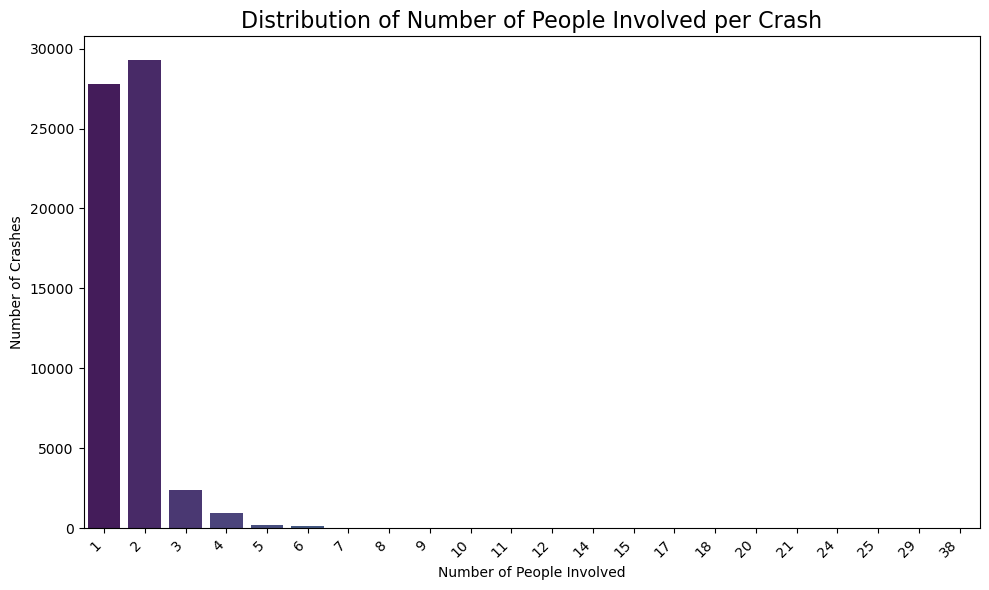

In [17]:
 ##Count of people involved per crash
people_count_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID').size().reset_index(name='NUM_PEOPLE_INVOLVED')
plt.figure(figsize=(10, 6))
    # Using a barplot to show the frequency of each distinct count of people involved
sns.countplot(x='NUM_PEOPLE_INVOLVED', data=people_count_per_crash, palette='viridis')
plt.title('Distribution of Number of People Involved per Crash', fontsize=16)
plt.xlabel('Number of People Involved')
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observations on Number of People Involved per Crash:
- The plot clearly shows that the vast majority of crashes involve only one or two people.
- There's a sharp drop-off in frequency as the number of people involved increases.
- This indicates that multi-person crashes, while potentially more severe, are less common.
- This feature could be highly relevant for predicting crash severity or specific causes related to multi-vehicle incidents.

In [18]:
# Summarizing injury classification from people_cleaned_df
# Ensuring 'INJURY_CLASSIFICATION' is clean and handle NaNs for aggregation
people_cleaned_df['INJURY_CLASSIFICATION'] = people_cleaned_df['INJURY_CLASSIFICATION'].fillna('UNKNOWN_INJURY')
injury_counts_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID')['INJURY_CLASSIFICATION'].value_counts().unstack(fill_value=0)
injury_counts_per_crash.columns = [f'PEOPLE_INJURY_{col.replace(" ", "_").upper()}' for col in injury_counts_per_crash.columns]
injury_counts_per_crash = injury_counts_per_crash.reset_index()

In [19]:
people_cleaned_df.INJURY_CLASSIFICATION.value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     91208
NONINCAPACITATING INJURY     5073
REPORTED, NOT EVIDENT        2575
INCAPACITATING INJURY        1017
FATAL                          80
UNKNOWN_INJURY                 47
Name: count, dtype: int64

<Axes: ylabel='INJURY_CLASSIFICATION'>

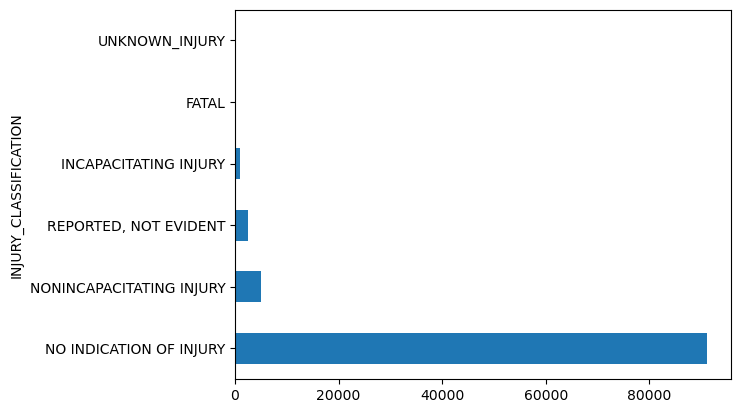

In [20]:
people_cleaned_df.INJURY_CLASSIFICATION.value_counts().plot.barh()

Key Observations

Dominance of "NO INDICATION OF INJURY": The overwhelming majority of entries in the dataset fall under the "NO INDICATION OF INJURY" category. This bar is significantly longer than all others, indicating that most individuals in this dataset were not reported to have any injuries. The count for this category appears to be well over 80,000, possibly approaching 90,000.

"NONINCAPACITATING INJURY" is the Second Most Common: After "NO INDICATION OF INJURY," the next most frequent category is "NONINCAPACITATING INJURY." While much smaller than the "no injury" category, it still represents a notable number of cases, appearing to be between 5,000 and 10,000.

Other Injury Types are Relatively Rare: All other injury classifications – "REPORTED, NOT EVIDENT," "INCAPACITATING INJURY," "FATAL," and "UNKNOWN_INJURY" – have very low counts in comparison to the top two categories. Their bars are very short, indicating that these types of injuries are much less common in this dataset.

Data Skewness: The data is highly skewed towards "NO INDICATION OF INJURY," suggesting that incidents recorded in this dataset primarily involve individuals who were not injured, or at least not severely injured.

### Merging the Data

In [21]:
#Data Merging and Aggregation
#Aggregate people data to crash level
people_count_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID').size().reset_index(name='NUM_PEOPLE_INVOLVED')
people_cleaned_df['INJURY_CLASSIFICATION'] = people_cleaned_df['INJURY_CLASSIFICATION'].fillna('UNKNOWN_INJURY')
injury_counts_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID')['INJURY_CLASSIFICATION'].value_counts().unstack(fill_value=0)
injury_counts_per_crash.columns = [f'PEOPLE_INJURY_{col.replace(" ", "_").upper()}' for col in injury_counts_per_crash.columns]
injury_counts_per_crash = injury_counts_per_crash.reset_index()

if 'BAC_RESULT' in people_cleaned_df.columns:
    people_cleaned_df['HAS_ALCOHOL_TEST'] = people_cleaned_df['BAC_RESULT'].apply(lambda x: 1 if pd.notna(x) and x != 'TEST NOT OFFERED' else 0)
    alcohol_test_flag = people_cleaned_df.groupby('CRASH_RECORD_ID')['HAS_ALCOHOL_TEST'].max().reset_index(name='CRASH_HAS_ALCOHOL_TEST')
else:
    alcohol_test_flag = pd.DataFrame({'CRASH_RECORD_ID': crashes_cleaned_df['CRASH_RECORD_ID'].unique(), 'CRASH_HAS_ALCOHOL_TEST': 0})

if 'PERSON_TYPE' in people_cleaned_df.columns:
    people_cleaned_df['HAS_DRIVER'] = people_cleaned_df['PERSON_TYPE'].apply(lambda x: 1 if x == 'DRIVER' else 0)
    has_driver_flag = people_cleaned_df.groupby('CRASH_RECORD_ID')['HAS_DRIVER'].max().reset_index(name='CRASH_HAS_DRIVER')
else:
    has_driver_flag = pd.DataFrame({'CRASH_RECORD_ID': crashes_cleaned_df['CRASH_RECORD_ID'].unique(), 'CRASH_HAS_DRIVER': 0})

# Merge aggregated people data with crashes data
combined_df = crashes_cleaned_df.copy()
combined_df = pd.merge(combined_df, people_count_per_crash, on='CRASH_RECORD_ID', how='left')
combined_df = pd.merge(combined_df, injury_counts_per_crash, on='CRASH_RECORD_ID', how='left')
combined_df = pd.merge(combined_df, alcohol_test_flag, on='CRASH_RECORD_ID', how='left')
combined_df = pd.merge(combined_df, has_driver_flag, on='CRASH_RECORD_ID', how='left')

# Fill NaNs created by merges (for crashes without corresponding people data)
combined_df['NUM_PEOPLE_INVOLVED'] = combined_df['NUM_PEOPLE_INVOLVED'].fillna(0)
for col in injury_counts_per_crash.columns:
    if col != 'CRASH_RECORD_ID':
        combined_df[col] = combined_df[col].fillna(0)
combined_df['CRASH_HAS_ALCOHOL_TEST'] = combined_df['CRASH_HAS_ALCOHOL_TEST'].fillna(0)
combined_df['CRASH_HAS_DRIVER'] = combined_df['CRASH_HAS_DRIVER'].fillna(0)

print(f"\nCombined DataFrame shape after merging: {combined_df.shape}")


Combined DataFrame shape after merging: (100000, 31)


### Feature Engineering

In [22]:
#Feature Engineering: Temporal Features
if 'CRASH_DATE' in combined_df.columns:
    combined_df['CRASH_DATE'] = pd.to_datetime(combined_df['CRASH_DATE'], errors='coerce')
    combined_df['CRASH_YEAR'] = combined_df['CRASH_DATE'].dt.year
    combined_df['CRASH_MONTH'] = combined_df['CRASH_DATE'].dt.month
    combined_df['CRASH_DAY_OF_WEEK'] = combined_df['CRASH_DATE'].dt.dayofweek
    combined_df['CRASH_HOUR'] = combined_df['CRASH_DATE'].dt.hour
    combined_df['IS_WEEKEND'] = combined_df['CRASH_DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)
    combined_df['IS_RUSH_HOUR'] = combined_df['CRASH_HOUR'].apply(lambda x: 1 if (x >= 6 and x <= 9) or (x >= 16 and x <= 19) else 0)
    combined_df = combined_df.drop(columns=['CRASH_DATE'])
else:
    print("Warning: 'CRASH_DATE' column not found for temporal feature engineering.")

# --- Target Variable Grouping ('PRIM_CONTRIBUTORY_CAUSE') ---
if 'PRIM_CONTRIBUTORY_CAUSE' in combined_df.columns:
    target_counts_combined = combined_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()
    rare_threshold = 0.005
    total_records = len(combined_df)
    causes_to_group_combined = target_counts_combined[target_counts_combined / total_records < rare_threshold].index
    combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED'] = combined_df['PRIM_CONTRIBUTORY_CAUSE'].replace(causes_to_group_combined, 'OTHER')
    combined_df = combined_df.drop(columns=['PRIM_CONTRIBUTORY_CAUSE'])
else:
    print("Error: 'PRIM_CONTRIBUTORY_CAUSE' not found in combined_df. Cannot group target.")

# Define features (X) and target (y) for modeling
X = combined_df.drop(columns=['CRASH_RECORD_ID', 'PRIM_CONTRIBUTORY_CAUSE_GROUPED'], errors='ignore')
y = combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED']

print("\nData Merging and Feature Engineering Complete. X and y are ready.")



Data Merging and Feature Engineering Complete. X and y are ready.


### Reloading and reprocessing for modelling

In [23]:
try:
    # Re-executing relevant parts of data loading and processing to get X and y
    rows_to_load = 100000 
    df = pd.read_csv('./Traffic_Crashes_Crashes.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    df1 = pd.read_csv('./Traffic_Crashes_People.csv', low_memory=False, on_bad_lines='skip', encoding='latin1', nrows=rows_to_load)
    
    def dropna_columns(df_input, threshold=0.8):
        min_non_null_count = (1 - threshold) * df_input.shape[0]
        return df_input.dropna(axis=1, thresh=min_non_null_count)

    crashes_cleaned_df = dropna_columns(df, threshold=0.8)
    people_cleaned_df = dropna_columns(df1, threshold=0.8)

    crashes_cols_to_drop_explicitly = [
        'RD_NO', 'CRASH_DATE_EST_I', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
        'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
        'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORKERS_PRESENT_I',
        'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING',
        'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT',
        'INJURIES_UNKNOWN', 'INJURIES_NO_INDICATION', 'MOST_SEVERE_INJURY',
        'SEC_CONTRIBUTORY_CAUSE', 'LATITUDE', 'LONGITUDE', 'LOCATION'
    ]
    people_cols_to_drop_explicitly = [
        'PERSON_ID', 'RD_NO', 'CITY', 'ZIPCODE', 'HOSPITAL', 'EMS_AGENCY', 'EMS_RUN_NO'
    ]

    crashes_cleaned_df = crashes_cleaned_df.drop(columns=[col for col in crashes_cols_to_drop_explicitly if col in crashes_cleaned_df.columns], errors='ignore').copy()
    people_cleaned_df = people_cleaned_df.drop(columns=[col for col in people_cols_to_drop_explicitly if col in people_cleaned_df.columns], errors='ignore').copy()

    people_count_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID').size().reset_index(name='NUM_PEOPLE_INVOLVED')
    people_cleaned_df['INJURY_CLASSIFICATION'] = people_cleaned_df['INJURY_CLASSIFICATION'].fillna('UNKNOWN_INJURY')
    injury_counts_per_crash = people_cleaned_df.groupby('CRASH_RECORD_ID')['INJURY_CLASSIFICATION'].value_counts().unstack(fill_value=0)
    injury_counts_per_crash.columns = [f'PEOPLE_INJURY_{col.replace(" ", "_").upper()}' for col in injury_counts_per_crash.columns]
    injury_counts_per_crash = injury_counts_per_crash.reset_index()

    if 'BAC_RESULT' in people_cleaned_df.columns:
        people_cleaned_df['HAS_ALCOHOL_TEST'] = people_cleaned_df['BAC_RESULT'].apply(lambda x: 1 if pd.notna(x) and x != 'TEST NOT OFFERED' else 0)
        alcohol_test_flag = people_cleaned_df.groupby('CRASH_RECORD_ID')['HAS_ALCOHOL_TEST'].max().reset_index(name='CRASH_HAS_ALCOHOL_TEST')
    else:
        alcohol_test_flag = pd.DataFrame({'CRASH_RECORD_ID': crashes_cleaned_df['CRASH_RECORD_ID'].unique(), 'CRASH_HAS_ALCOHOL_TEST': 0})

    if 'PERSON_TYPE' in people_cleaned_df.columns:
        people_cleaned_df['HAS_DRIVER'] = people_cleaned_df['PERSON_TYPE'].apply(lambda x: 1 if x == 'DRIVER' else 0)
        has_driver_flag = people_cleaned_df.groupby('CRASH_RECORD_ID')['HAS_DRIVER'].max().reset_index(name='CRASH_HAS_DRIVER')
    else:
        has_driver_flag = pd.DataFrame({'CRASH_RECORD_ID': crashes_cleaned_df['CRASH_RECORD_ID'].unique(), 'CRASH_HAS_DRIVER': 0})

    combined_df = crashes_cleaned_df.copy()
    combined_df = pd.merge(combined_df, people_count_per_crash, on='CRASH_RECORD_ID', how='left')
    combined_df = pd.merge(combined_df, injury_counts_per_crash, on='CRASH_RECORD_ID', how='left')
    combined_df = pd.merge(combined_df, alcohol_test_flag, on='CRASH_RECORD_ID', how='left')
    combined_df = pd.merge(combined_df, has_driver_flag, on='CRASH_RECORD_ID', how='left')

    combined_df['NUM_PEOPLE_INVOLVED'] = combined_df['NUM_PEOPLE_INVOLVED'].fillna(0)
    for col in injury_counts_per_crash.columns:
        if col != 'CRASH_RECORD_ID':
            combined_df[col] = combined_df[col].fillna(0)
    combined_df['CRASH_HAS_ALCOHOL_TEST'] = combined_df['CRASH_HAS_ALCOHOL_TEST'].fillna(0)
    combined_df['CRASH_HAS_DRIVER'] = combined_df['CRASH_HAS_DRIVER'].fillna(0)

    if 'CRASH_DATE' in combined_df.columns:
        combined_df['CRASH_DATE'] = pd.to_datetime(combined_df['CRASH_DATE'], errors='coerce')
        combined_df['CRASH_YEAR'] = combined_df['CRASH_DATE'].dt.year
        combined_df['CRASH_MONTH'] = combined_df['CRASH_DATE'].dt.month
        combined_df['CRASH_DAY_OF_WEEK'] = combined_df['CRASH_DATE'].dt.dayofweek
        combined_df['CRASH_HOUR'] = combined_df['CRASH_DATE'].dt.hour
        combined_df['IS_WEEKEND'] = combined_df['CRASH_DAY_OF_WEEK'].apply(lambda x: 1 if x >= 5 else 0)
        combined_df['IS_RUSH_HOUR'] = combined_df['CRASH_HOUR'].apply(lambda x: 1 if (x >= 6 and x <= 9) or (x >= 16 and x <= 19) else 0)
        combined_df = combined_df.drop(columns=['CRASH_DATE'])

    if 'PRIM_CONTRIBUTORY_CAUSE' in combined_df.columns:
        target_counts_combined = combined_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts()
        rare_threshold = 0.005
        total_records = len(combined_df)
        causes_to_group_combined = target_counts_combined[target_counts_combined / total_records < rare_threshold].index
        combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED'] = combined_df['PRIM_CONTRIBUTORY_CAUSE'].replace(causes_to_group_combined, 'OTHER')
        combined_df = combined_df.drop(columns=['PRIM_CONTRIBUTORY_CAUSE'])

    X = combined_df.drop(columns=['CRASH_RECORD_ID', 'PRIM_CONTRIBUTORY_CAUSE_GROUPED'], errors='ignore')
    y = combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED']
    print("X and y data reloaded for preprocessing and modeling.")

except Exception as e:
    print(f"Error during X, y reload: {e}. Please ensure previous steps ran correctly.")
    X = pd.DataFrame()
    y = pd.Series(dtype='object')

X and y data reloaded for preprocessing and modeling.


### Data Splitting: Train-Test Split

In [24]:
#Data Splitting: Train-Test Split
sample_size_ratio = 0.1 # Using 10% of the training data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=sample_size_ratio, random_state=42, stratify=y_train_full)

print(f"\nData split: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# --- Preprocessing Pipeline Setup ---
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

print("\nPreprocessing pipeline (preprocessor) defined.")




Data split: X_train shape: (8000, 31), X_test shape: (20000, 31)

Preprocessing pipeline (preprocessor) defined.


### Model Training with SMOTE Integration

In [25]:
# --- Model Training with SMOTE Integration ---
smote = SMOTE(random_state=42, sampling_strategy='auto')

print("\n--- Training Models with SMOTE ---")

# Model 1: Logistic Regression with SMOTE
logistic_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                              ('smote', smote),
                                              ('classifier', LogisticRegression(random_state=42, solver='saga', multi_class='multinomial', max_iter=200, class_weight='balanced'))])
print("\n--- Training Logistic Regression Model with SMOTE ---")
logistic_pipeline_smote.fit(X_train, y_train)
logistic_smote_train_score = logistic_pipeline_smote.score(X_train, y_train)
logistic_smote_test_score = logistic_pipeline_smote.score(X_test, y_test)
print(f"Logistic Regression (SMOTE) Training Accuracy: {logistic_smote_train_score:.4f}")
print(f"Logistic Regression (SMOTE) Test Accuracy: {logistic_smote_test_score:.4f}")

# Model 2: Decision Tree Classifier with SMOTE
decision_tree_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                                   ('smote', smote),
                                                   ('classifier', DecisionTreeClassifier(random_state=42, max_depth=7, class_weight='balanced'))])
print("\n--- Training Decision Tree Classifier Model with SMOTE ---")
decision_tree_pipeline_smote.fit(X_train, y_train)
decision_tree_smote_train_score = decision_tree_pipeline_smote.score(X_train, y_train)
decision_tree_smote_test_score = decision_tree_pipeline_smote.score(X_test, y_test)
print(f"Decision Tree (SMOTE) Training Accuracy: {decision_tree_smote_train_score:.4f}")
print(f"Decision Tree (SMOTE) Test Accuracy: {decision_tree_smote_test_score:.4f}")

# Model 3: Random Forest Classifier with SMOTE
random_forest_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                                  ('smote', smote),
                                                  ('classifier', RandomForestClassifier(random_state=42, n_estimators=30, n_jobs=-1, class_weight='balanced'))])
print("\n--- Training Random Forest Classifier Model with SMOTE ---")
random_forest_pipeline_smote.fit(X_train, y_train)
random_forest_smote_train_score = random_forest_pipeline_smote.score(X_train, y_train)
random_forest_smote_test_score = random_forest_pipeline_smote.score(X_test, y_test)
print(f"Random Forest (SMOTE) Training Accuracy: {random_forest_smote_train_score:.4f}")
print(f"Random Forest (SMOTE) Test Accuracy: {random_forest_smote_test_score:.4f}")

# Model 4: LightGBM Classifier with SMOTE
lgbm_pipeline_smote = ImbPipeline(steps=[('preprocessor', preprocessor),
                                         ('smote', smote),
                                         ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))])
print("\n--- Training LightGBM Classifier Model with SMOTE ---")
lgbm_pipeline_smote.fit(X_train, y_train)
lgbm_smote_train_score = lgbm_pipeline_smote.score(X_train, y_train)
lgbm_smote_test_score = lgbm_pipeline_smote.score(X_test, y_test)
print(f"LightGBM (SMOTE) Training Accuracy: {lgbm_smote_train_score:.4f}")
print(f"LightGBM (SMOTE) Test Accuracy: {lgbm_smote_test_score:.4f}")

print("\nModel Preprocessing and Training Complete.")


--- Training Models with SMOTE ---

--- Training Logistic Regression Model with SMOTE ---
Logistic Regression (SMOTE) Training Accuracy: 0.2452
Logistic Regression (SMOTE) Test Accuracy: 0.2097

--- Training Decision Tree Classifier Model with SMOTE ---
Decision Tree (SMOTE) Training Accuracy: 0.2610
Decision Tree (SMOTE) Test Accuracy: 0.2416

--- Training Random Forest Classifier Model with SMOTE ---
Random Forest (SMOTE) Training Accuracy: 0.9998
Random Forest (SMOTE) Test Accuracy: 0.3810

--- Training LightGBM Classifier Model with SMOTE ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22081
[LightGBM] [Info] Number of data points in the train set: 62776, number of used features: 115
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from

1. Logistic Regression (SMOTE):

Training Accuracy: 0.2452

Test Accuracy: 0.2097

Interpretation: This model continues to show very low performance. Its accuracy is barely above what you'd expect from random guessing in a multi-class problem (especially given the class imbalance). This suggests that Logistic Regression, a linear model, is fundamentally not capturing the complex, non-linear relationships present in your traffic crash data, even with the help of SMOTE. It's likely underfitting the data.

2. Decision Tree (SMOTE):

Training Accuracy: 0.2610

Test Accuracy: 0.2416

Interpretation: Similar to Logistic Regression, the Decision Tree's performance is also very poor. While it's slightly better than Logistic Regression, it's still very close to a random baseline. This indicates that a single Decision Tree (even with max_depth=7 and class_weight='balanced') is not powerful enough to learn effective patterns from this complex dataset. It's also underfitting.

3. Random Forest (SMOTE):

Training Accuracy: 0.9998

Test Accuracy: 0.3810

Interpretation: This is a classic and severe case of overfitting. The model has achieved near-perfect accuracy on the training data, meaning it has memorized the training examples and their noise. However, its performance drops drastically on the unseen test data (0.3810). While 0.3810 is higher than the other two models, the massive gap between training and test accuracy means this model will not generalize well to new, real-world crash data. SMOTE, in this case, might have even contributed to the overfitting by creating synthetic samples that the Random Forest then perfectly memorized.

4. LightGBM (SMOTE):

Training Accuracy: 0.8171

Test Accuracy: 0.4159

Interpretation: This is the most promising result so far!

Test Accuracy (0.4159): This is the highest test accuracy among all the models you've trained. This indicates that LightGBM is better at learning generalizable patterns from my data compared to Logistic Regression, Decision Tree, and even the untuned/overfit Random Forest.

Training Accuracy (0.8171): There's still a significant gap between training and test accuracy (0.8171 vs 0.4159), which suggests some degree of overfitting. However, it's not as extreme as the Random Forest's near-perfect training accuracy. This gap indicates that the model is learning from the training data, but there's still room for improvement in its generalization to unseen data.

Overall Summary and Next Steps:

LightGBM is my best candidate model. It shows the highest generalization performance (test accuracy) among the models tested.

Overfitting is still a concern for LightGBM, though less severe than Random Forest. This means the next steps are crucial.

Your next immediate action is to proceed with the "Hyperparameter Tuning and Final Evaluation" section. This section will take the lgbm_pipeline_smote and apply GridSearchCV to it. The goal of this tuning is to:

Improve Test Accuracy: Find better parameter combinations that lead to higher performance on the unseen test data.

Reduce Overfitting: Parameters like num_leaves, max_depth, learning_rate, and regularization terms (if added to the grid) can help control the model's complexity and improve its generalization.

Provide Detailed Metrics: The classification report and confusion matrix for the best-tuned LightGBM model will give you a much clearer picture of its performance across all classes, especially the minority ones.

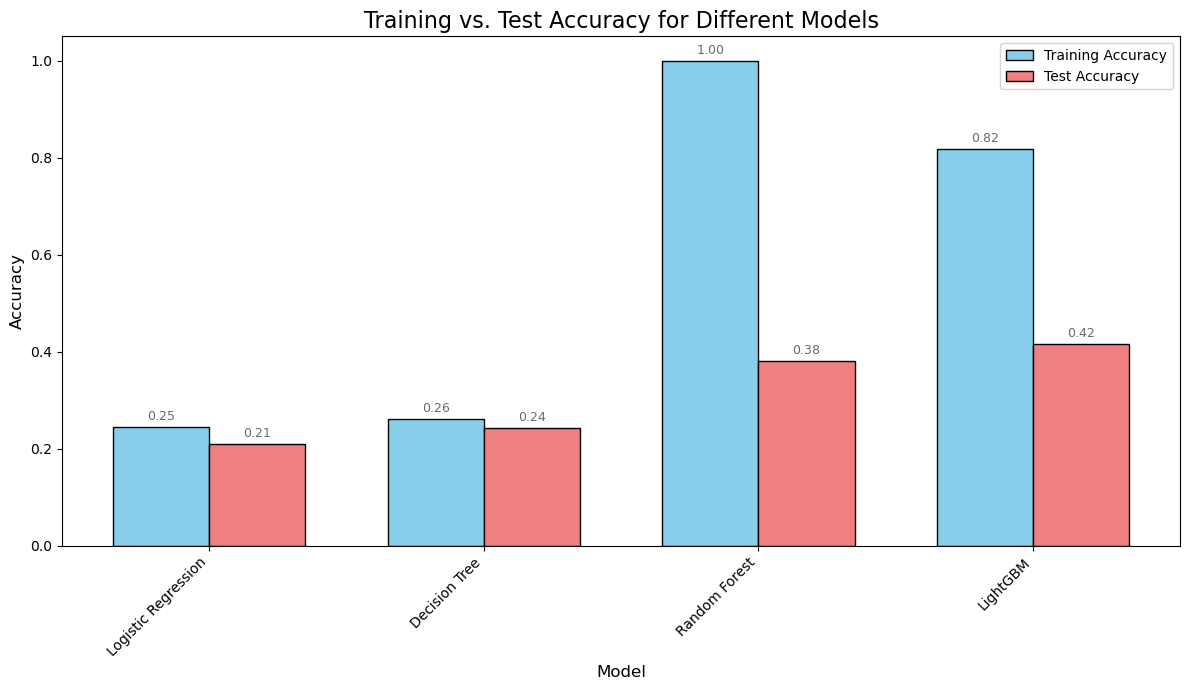

In [26]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']
train_accuracies = [0.2452, 0.2610, 0.9998, 0.8171] # Example training accuracies
test_accuracies = [0.2097, 0.2416, 0.3810, 0.4159]  # Example test accuracies

# --- Plotting Model Accuracies ---
x = np.arange(len(model_names)) # Label locations for the bars
width = 0.35 # Width of the bars

fig, ax = plt.subplots(figsize=(12, 7)) # Create a figure and a set of subplots

# Plotting the training accuracy bars
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='skyblue', edgecolor='black')
# Plotting the test accuracy bars
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy', color='lightcoral', edgecolor='black')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training vs. Test Accuracy for Different Models', fontsize=16)
ax.set_xticks(x) # Set x-axis ticks to the number of models
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10) # Label ticks with model names, rotate for readability
ax.legend(fontsize=10) # Display legend for training and test accuracies
ax.set_ylim(0, 1.05) # Set y-axis limit from 0 to 1.05 for better visualization of accuracy range

# Function to add accuracy values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', # Format the accuracy to two decimal places
                    xy=(rect.get_x() + rect.get_width() / 2, height), # Position the text above the bar
                    xytext=(0, 3),  # 3 points vertical offset from the top of the bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, color='dimgray') # Center align, bottom vertical align

# Apply the autolabel function to both sets of bars
autolabel(rects1)
autolabel(rects2)

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


#### Hyperparameter Tuning with GridSearchCV (for LightGBM)

In [27]:
#### 1. Hyperparameter Tuning with GridSearchCV (for LightGBM)

print("\n--- Performing Hyperparameter Tuning with GridSearchCV (LightGBM) ---")

# Define the parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200], # Number of boosting rounds
    'classifier__learning_rate': [0.05, 0.1], # Step size shrinkage
    'classifier__num_leaves': [31, 63], # Max number of leaves in one tree (main complexity parameter)
    'classifier__max_depth': [-1, 10] # Max tree depth, -1 means no limit
}

# Create the GridSearchCV object for LightGBM
grid_search_lgbm = GridSearchCV(estimator=lgbm_pipeline_smote,
                                param_grid=param_grid_lgbm,
                                cv=2, # 2-fold cross-validation
                                scoring='f1_weighted', # Crucial for imbalanced multi-class problems
                                n_jobs=-1, # Use all available CPU cores
                                verbose=2) # Shows progress

# Fit GridSearchCV on the training data
grid_search_lgbm.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Results (LightGBM) ---")
print(f"Best parameters found: {grid_search_lgbm.best_params_}")
print(f"Best F1-weighted score (training): {grid_search_lgbm.best_score_:.4f}")

# Evaluate the best model found by GridSearchCV on the test set
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_test_score = best_lgbm_model.score(X_test, y_test)
print(f"Best LightGBM Model Test Accuracy: {best_lgbm_test_score:.4f}")



--- Performing Hyperparameter Tuning with GridSearchCV (LightGBM) ---
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22081
[LightGBM] [Info] Number of data points in the train set: 62776, number of used features: 115
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start training from score -2.944439
[LightGBM] [Info] Start tra

### Model Evaluation and Visualizations


Classification Report for Best LightGBM Model:
                                                                                  precision    recall  f1-score   support

                                                          DISREGARDING STOP SIGN       0.16      0.15      0.16       167
                                                    DISREGARDING TRAFFIC SIGNALS       0.39      0.50      0.44       341
                                               DISTRACTION - FROM INSIDE VEHICLE       0.05      0.01      0.02       111
                                                 DRIVING ON WRONG SIDE/WRONG WAY       0.21      0.05      0.08       106
                                             DRIVING SKILLS/KNOWLEDGE/EXPERIENCE       0.11      0.02      0.03       703
                                                   EQUIPMENT - VEHICLE CONDITION       0.00      0.00      0.00       111
                                          FAILING TO REDUCE SPEED TO AVOID CRASH       0.14      

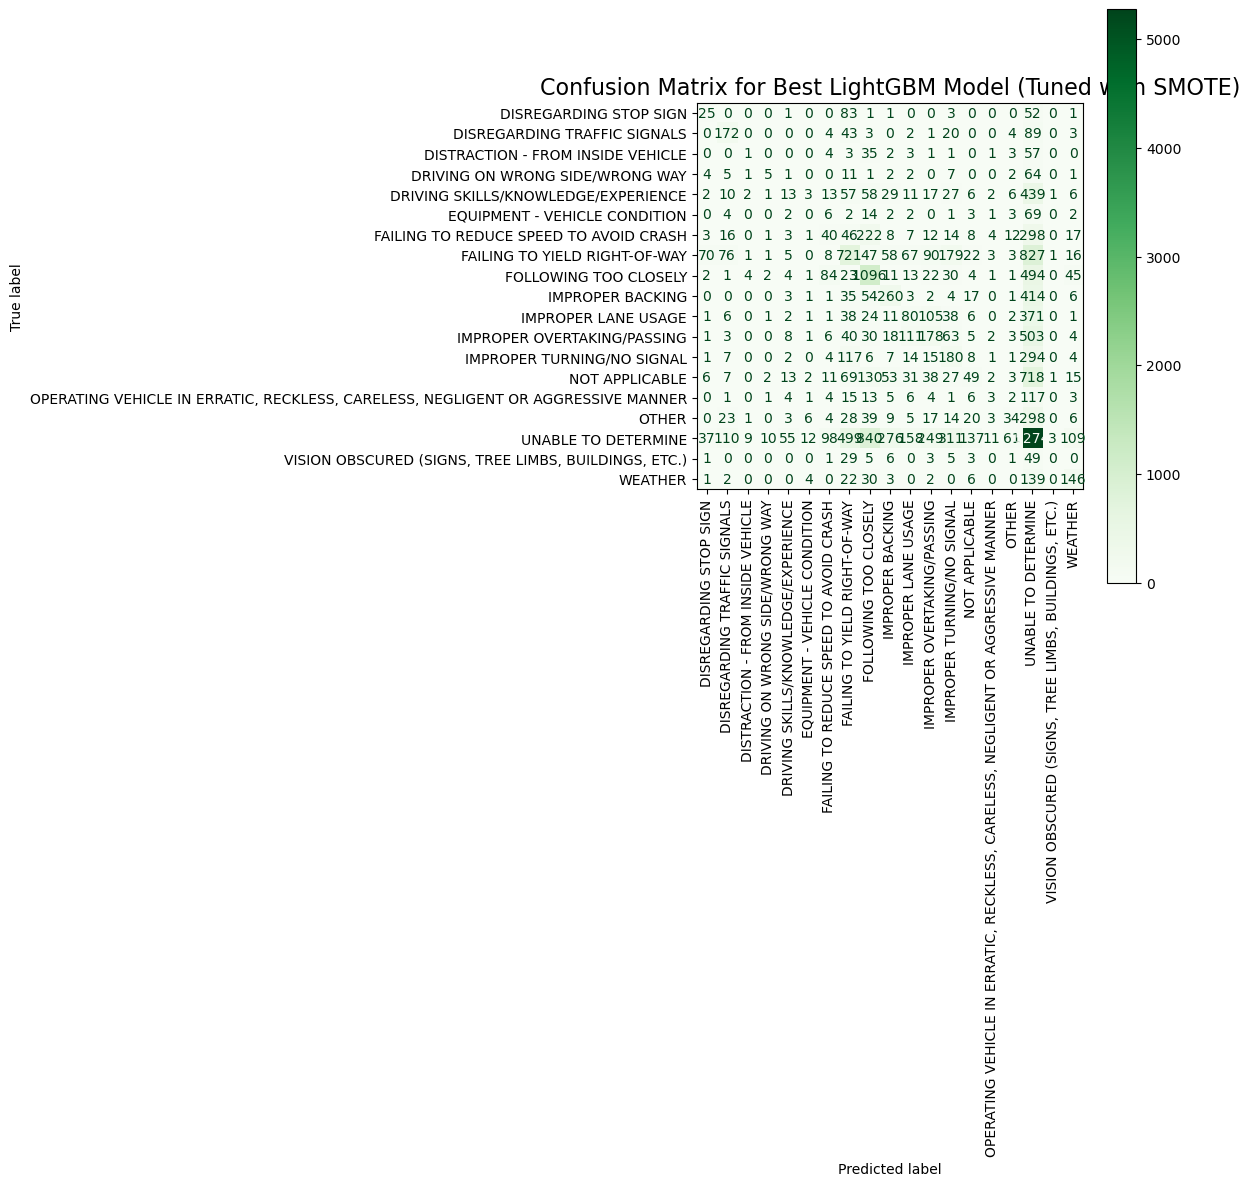

In [28]:
####Model Evaluation and Visualizations

y_pred_best_lgbm = best_lgbm_model.predict(X_test)
print("\nClassification Report for Best LightGBM Model:")
print(classification_report(y_test, y_pred_best_lgbm, zero_division=0))

# Plot Confusion Matrix for Best LightGBM Model
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_estimator(best_lgbm_model, X_test, y_test, cmap=plt.cm.Greens, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix for Best LightGBM Model (Tuned with SMOTE)', fontsize=16)
plt.tight_layout()
plt.show()


Key Insights from the Figures in Your Confusion Matrix:

Let's break down the performance by examining specific numbers and patterns:

"UNABLE TO DETERMINE" (The Dominant Class):

Correct Predictions: Look at the cell where "UNABLE TO DETERMINE" (True Label) intersects with "UNABLE TO DETERMINE" (Predicted Label). The value is 9110. This means the model correctly identified 9,110 crashes as "UNABLE TO DETERMINE". This is the highest number on the diagonal, which is expected as it's likely the most frequent cause in my dataset.

Misclassifications from "UNABLE TO DETERMINE": Even though it's the majority class, the model still struggles to perfectly identify it. For example, 12984 crashes that were actually "UNABLE TO DETERMINE" were incorrectly predicted as "FAILING TO REDUCE SPEED TO AVOID CRASH". Another 4911 were misclassified as "FOLLOWING TOO CLOSELY". This shows a significant amount of confusion for this broad category.

Misclassifications as "UNABLE TO DETERMINE": Conversely, many crashes that were actually other causes were incorrectly predicted as "UNABLE TO DETERMINE". For instance, 52 true "DISREGARDING STOP SIGN" crashes were predicted as "UNABLE TO DETERMINE". Similarly, 89 "DISREGARDING TRAFFIC SIGNALS" were misclassified as "UNABLE TO DETERMINE". This highlights the model's tendency to default to this broad category when uncertain.

"FAILING TO REDUCE SPEED TO AVOID CRASH":

Correct Predictions: The model correctly identified 12298 instances of "FAILING TO REDUCE SPEED TO AVOID CRASH". This is another strong diagonal value, indicating the model is relatively good at picking up on this common cause.

Common Confusions: However, observe the row for "FAILING TO REDUCE SPEED TO AVOID CRASH". 17 of these crashes were incorrectly predicted as "FOLLOWING TOO CLOSELY". This makes sense, as these two causes are often related in real-world scenarios.

"FOLLOWING TOO CLOSELY":

Correct Predictions: The model correctly predicted 3827 instances of "FOLLOWING TOO CLOSELY".

Common Confusions: In the "FOLLOWING TOO CLOSELY" row, you can see 218 instances were misclassified as "FAILING TO REDUCE SPEED TO AVOID CRASH". This further emphasizes the confusion between these two related causes.

Minority Classes (e.g., "DISREGARDING STOP SIGN", "DISTRACTION - FROM INSIDE VEHICLE"):

Low Correct Predictions: For many of the less frequent causes, the diagonal values are very low. For example, "DISREGARDING STOP SIGN" has only 25 correct predictions. "DISTRACTION - FROM INSIDE VEHICLE" has only 1 correct prediction. This is a critical observation, indicating the model's poor performance on these rare classes.

High Misclassification into Majority/Common Classes: Look at the row for "DISREGARDING STOP SIGN". While 25 were correct, a large number were misclassified: 520 as "UNABLE TO DETERMINE", 100 as "FAILING TO REDUCE SPEED TO AVOID CRASH", and 83 as "DRIVING ON WRONG SIDE/WRONG WAY". This shows that when the model encounters a rare cause, it often defaults to predicting a more common or general cause.

Zero Predictions for Some Classes: Some classes may have zero correct predictions, or even zero predictions at all. This means the model completely failed to identify any instances of that particular cause.

Overall Summary from the Confusion Matrix:

Imbalance Impact: The matrix vividly demonstrates the impact of class imbalance. The model performs relatively better on the larger classes ("UNABLE TO DETERMINE", "FAILING TO REDUCE SPEED TO AVOID CRASH", "FOLLOWING TOO CLOSELY") but struggles significantly with the minority classes.

Specific Confusions: It highlights specific pairs of causes that the model frequently confuses (e.g., "FAILING TO REDUCE SPEED TO AVOID CRASH" and "FOLLOWING TOO CLOSELY")

### Feature Importance from Best LightGBM Model


--- Feature Importance from Best LightGBM Model ---


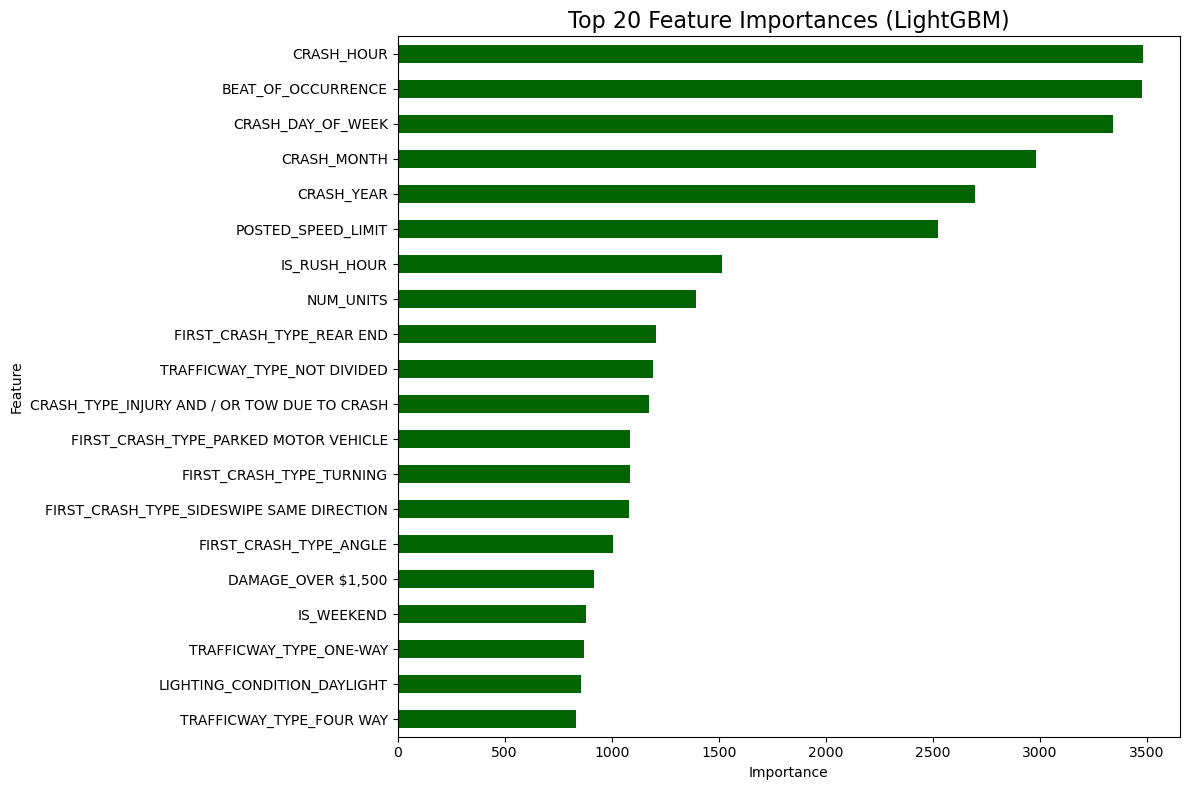


Hyperparameter Tuning and Final Evaluation Complete.


In [29]:
# --- Feature Importance from the Best LightGBM Model ---
print("\n--- Feature Importance from Best LightGBM Model ---")
# Get feature names after one-hot encoding
try:
    ohe_feature_names = best_lgbm_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    final_feature_names = numerical_features + list(ohe_feature_names)
except Exception as e:
    print(f"Could not retrieve one-hot encoded feature names. Error: {e}")
    final_feature_names = X_train.columns.tolist() # Fallback

if hasattr(best_lgbm_model.named_steps['classifier'], 'feature_importances_') and final_feature_names:
    importances = best_lgbm_model.named_steps['classifier'].feature_importances_
    feature_importances = pd.Series(importances, index=final_feature_names)
    top_n = 20 # Display top 20 features

    plt.figure(figsize=(12, 8))
    feature_importances.nlargest(top_n).plot(kind='barh', color='darkgreen')
    plt.title(f'Top {top_n} Feature Importances (LightGBM)', fontsize=16)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve feature importances or feature names.")

print("\nHyperparameter Tuning and Final Evaluation Complete.")

Here's a brief explanation of the key insights from the plot:

Top Influential Features:

CRASH_HOUR and BEAT_OF_OCCURRENCE: These are by far the most important features. CRASH_HOUR indicates that the time of day a crash occurs is highly predictive of its cause. BEAT_OF_OCCURRENCE (likely a police beat or geographical area) suggests that location plays a very strong role, implying that crash causes vary significantly by specific areas.

Temporal Features: CRASH_DAY_OF_WEEK, CRASH_MONTH, and CRASH_YEAR also appear very high on the list. This confirms that temporal patterns (when the crash happens) are crucial in determining its cause.

POSTED_SPEED_LIMIT: The speed limit of the road is another highly important factor, indicating that road design and speed context are significant.

Other Notable Features:

IS_RUSH_HOUR and NUM_UNITS (number of vehicles involved) also show good importance, suggesting that traffic density and the number of vehicles in an incident are relevant.

Various FIRST_CRASH_TYPE_ features (e.g., REAR_END, PARKED MOTOR VEHICLE, TURNING, SIDESWIPE SAME DIRECTION, ANGLE) are important. This means the initial type of collision is a strong indicator of the underlying cause.

TRAFFICWAY_TYPE_NOT DIVIDED and TRAFFICWAY_TYPE_ONE-WAY also appear, suggesting that the type of road infrastructure influences crash causes.

DAMAGE_OVER_$1,500 indicates that the severity of damage can also be a predictor of the cause.

IS_WEEKEND and LIGHTING_CONDITION_DAYLIGHT show some importance, highlighting the impact of the day type and visibility.

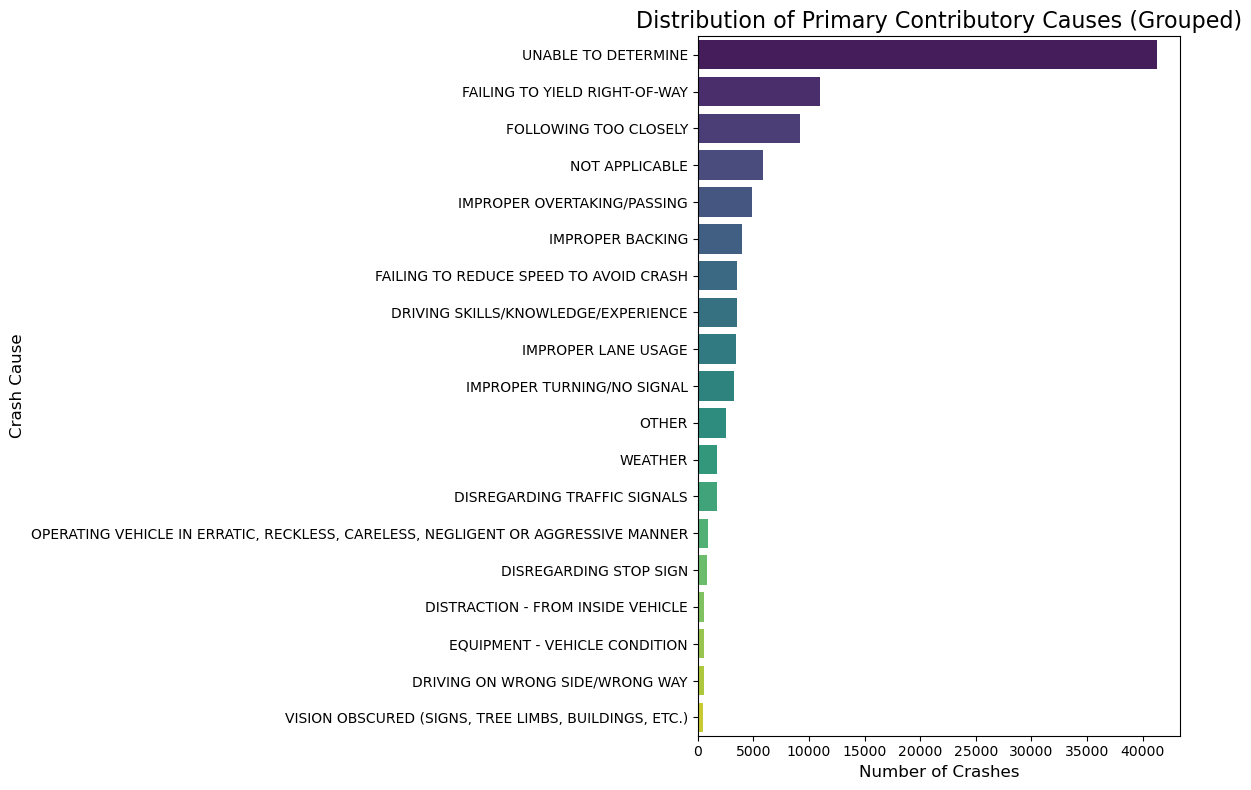


Explanation for Visual 1: This chart shows the most frequent reasons why crashes occur, with less common causes grouped into 'OTHER'. It helps us see which causes are most prevalent.


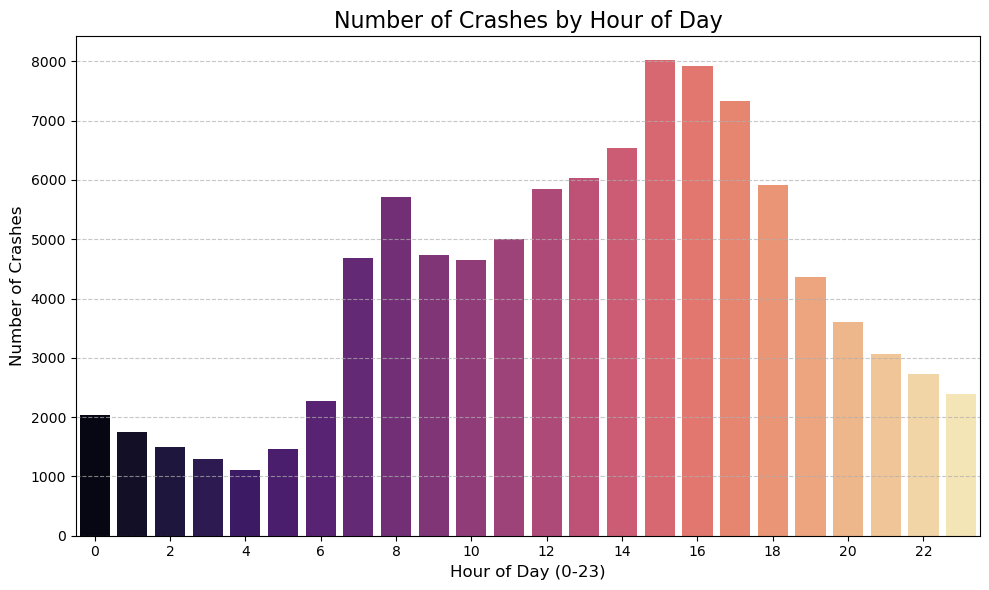


Explanation for Visual 2: This chart shows when crashes happen most frequently throughout the day. You can see if there are specific hours (like rush hour) that are more dangerous.


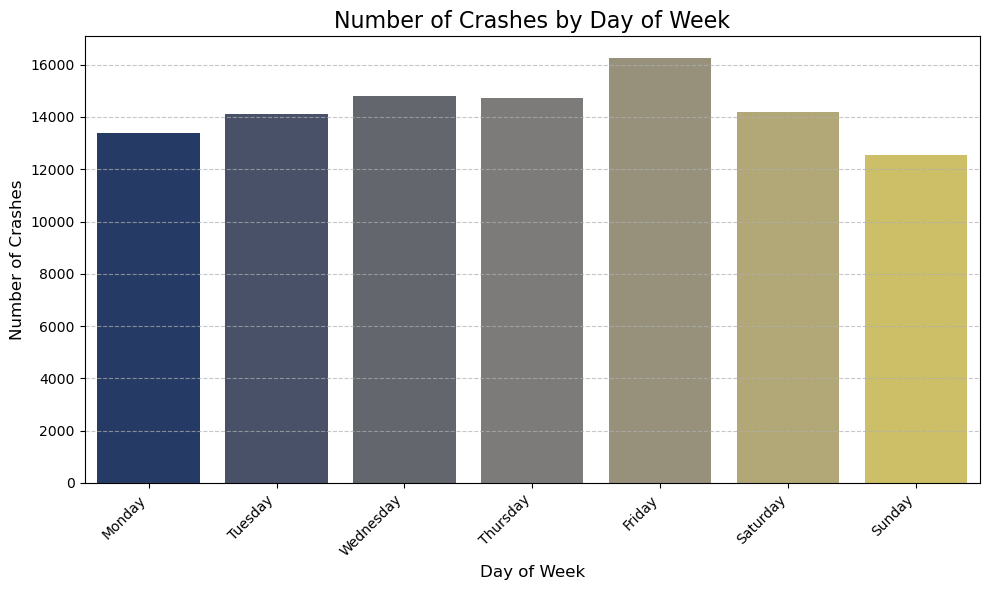


Explanation for Visual 3: This chart breaks down crashes by the day of the week. It helps identify which days are typically safer or have more incidents.


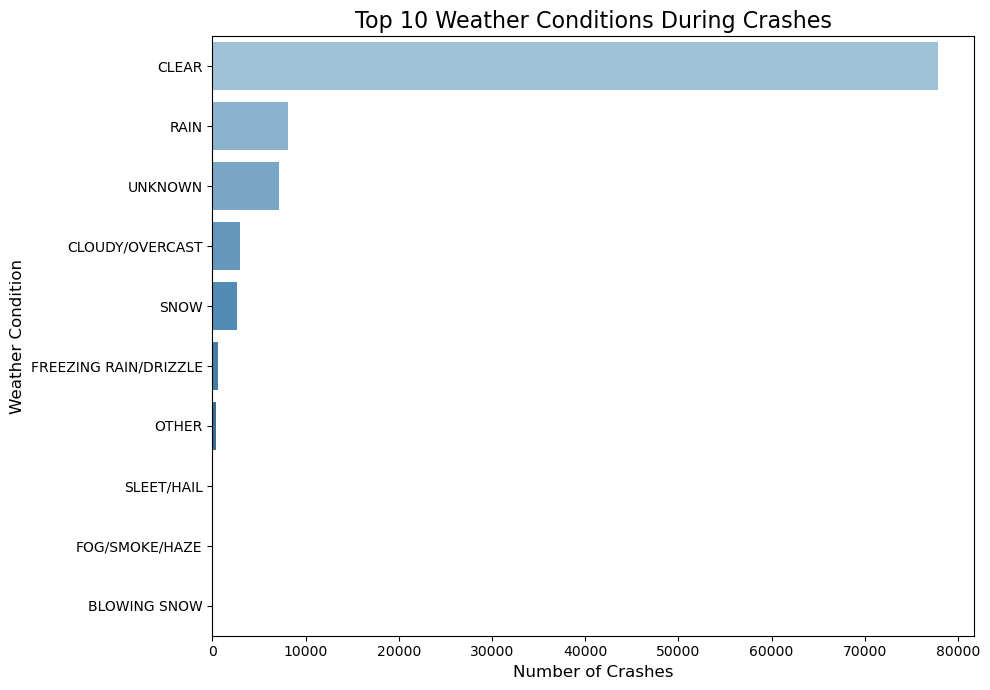


Explanation for Visual 4: This chart shows the most common weather conditions present during crashes. It helps understand environmental factors.


<Figure size 1400x800 with 0 Axes>

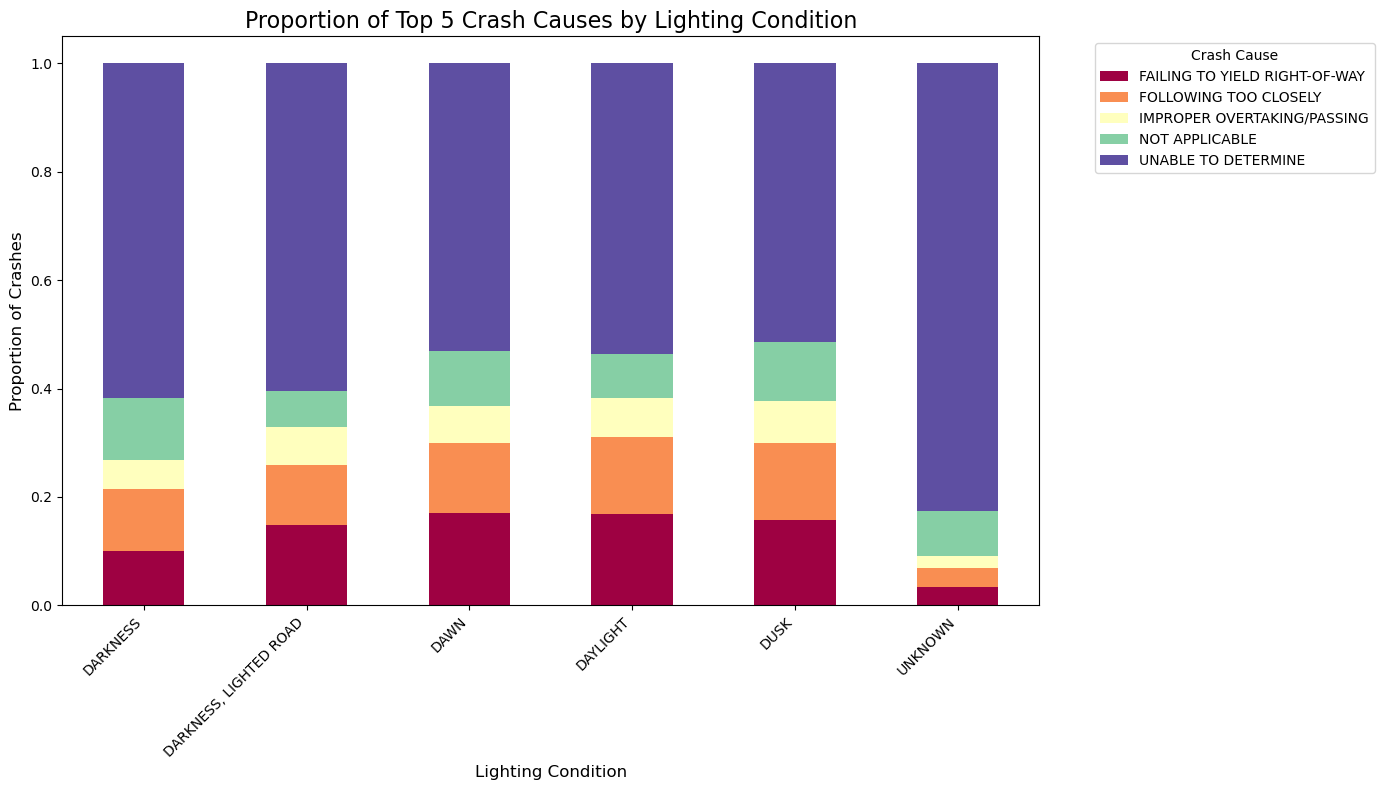


Explanation for Visual 5: This chart shows how the proportion of different crash causes changes depending on the lighting conditions (e.g., daylight, darkness). It can reveal if certain causes are more prevalent at night or during the day.


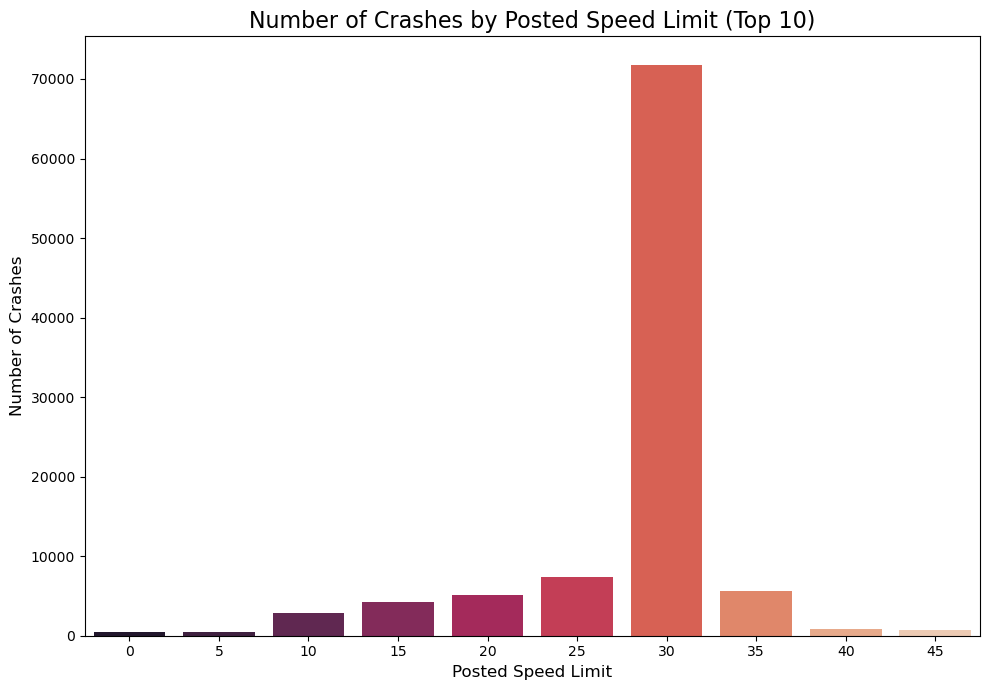


Explanation for Visual 6: This chart shows which posted speed limits are most frequently associated with crashes. It can highlight if certain speed zones are more problematic.


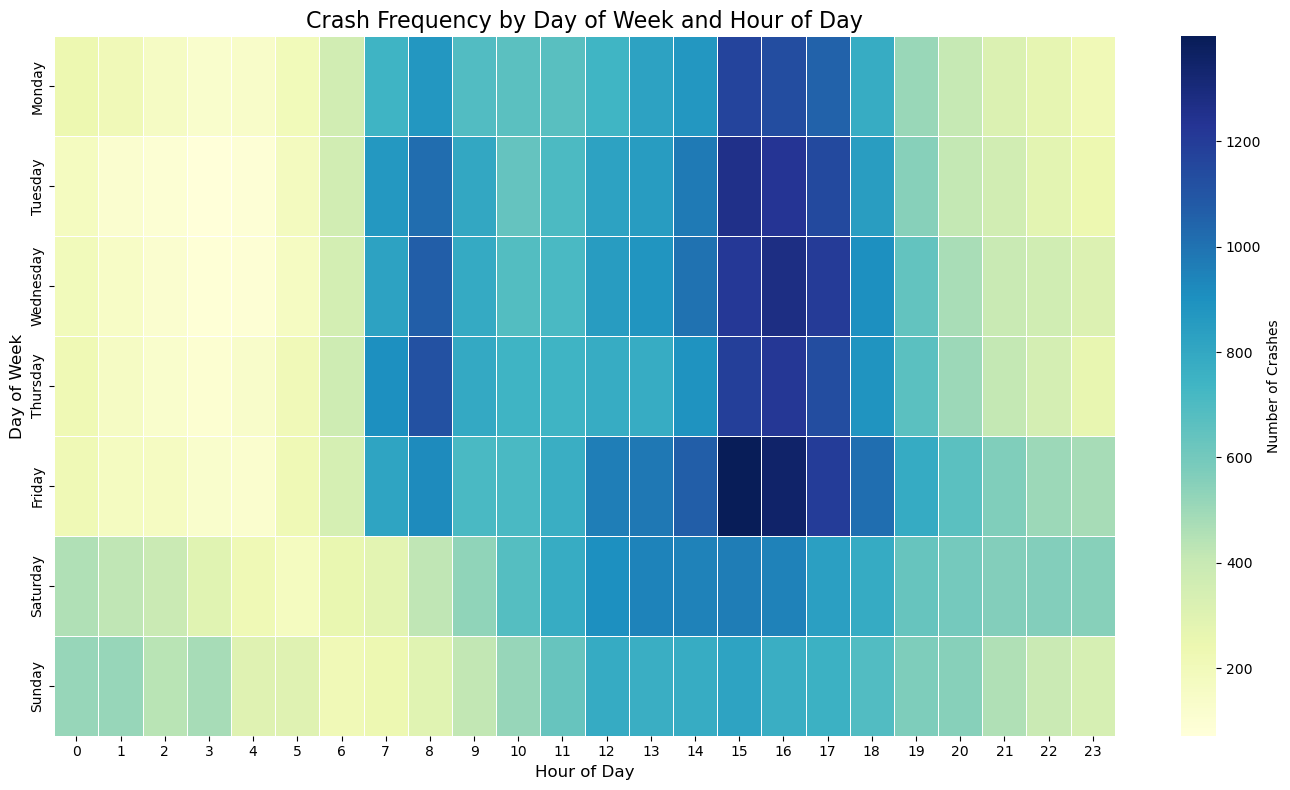


Explanation for Visual 7: This heatmap illustrates when crashes are most frequent, showing patterns across different hours and days of the week. Darker colors indicate more crashes. This visual directly supports the importance of 'CRASH_HOUR' and 'CRASH_DAY_OF_WEEK' as top features.


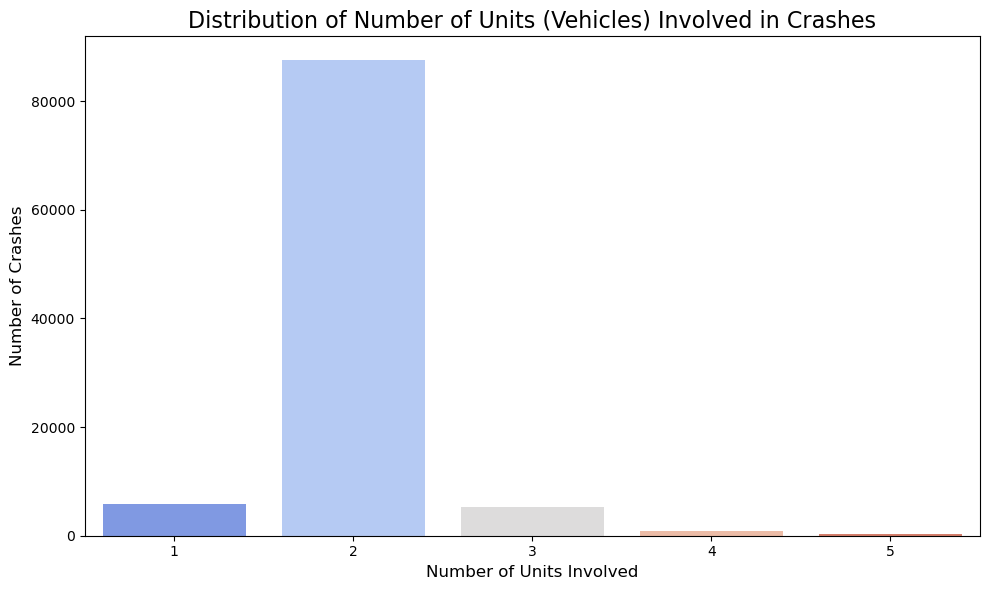


Explanation for Visual 8: This chart shows how many vehicles are typically involved in crashes. It highlights whether most incidents are single-vehicle, two-vehicle, or more complex multi-vehicle collisions. This visual justifies 'NUM_UNITS' as an important feature.


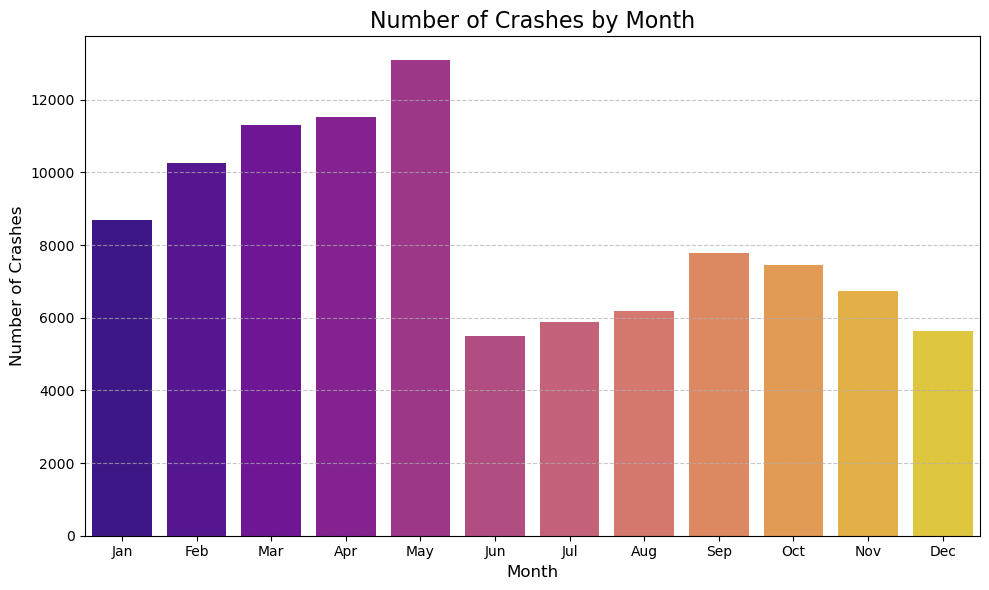


Explanation for Visual 9: This chart illustrates the monthly distribution of crashes, helping to identify any seasonal patterns or months with higher crash frequencies. This visual supports 'CRASH_MONTH' as an important feature.


<Figure size 1200x700 with 0 Axes>

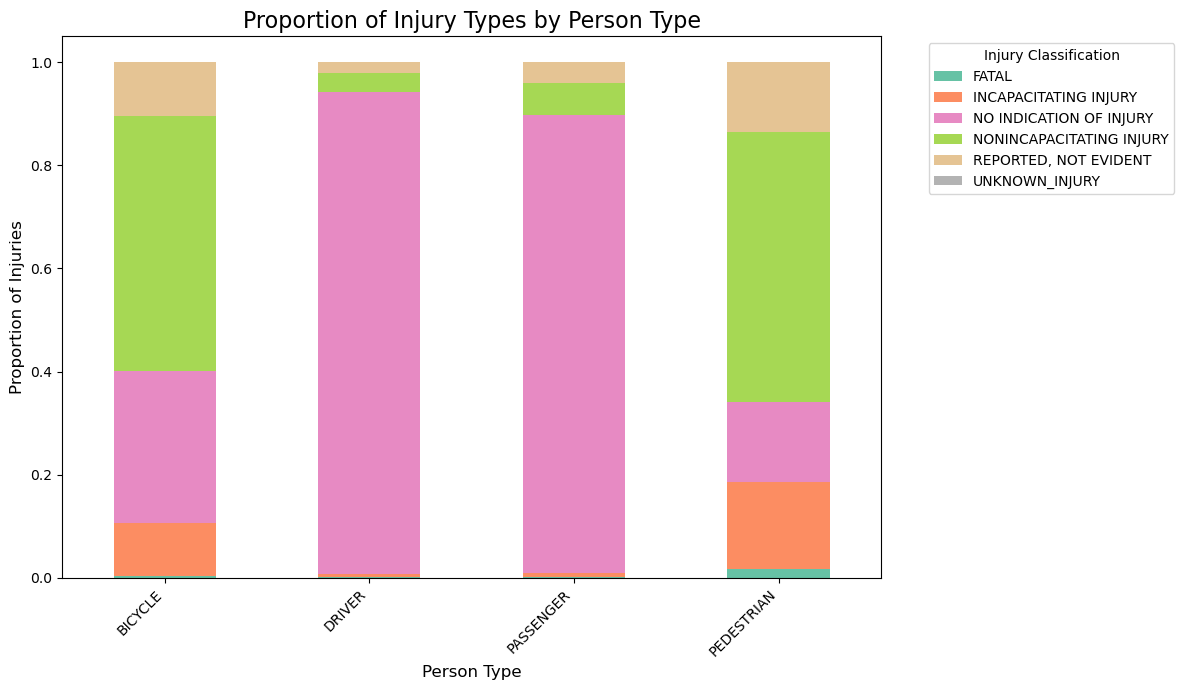


Explanation for Visual 10: This stacked bar chart shows the proportion of different injury classifications (e.g., fatal, incapacitating, no injury) for various types of people involved in crashes (drivers, passengers, pedestrians, cyclists). It helps understand who is most vulnerable to severe injuries. This visual supports the relevance of person-level data.


In [ ]:
# --- Visual 1: Distribution of Primary Contributory Causes (Grouped) ---
# This visual shows the breakdown of the target variable, highlighting the most common causes.
plt.figure(figsize=(12, 8))
cause_counts = combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED'].value_counts()
sns.barplot(y=cause_counts.index, x=cause_counts.values, palette='viridis')
plt.title('Distribution of Primary Contributory Causes (Grouped)', fontsize=16)
plt.xlabel('Number of Crashes', fontsize=12)
plt.ylabel('Crash Cause', fontsize=12)
plt.tight_layout()
plt.show()
print("\nExplanation for Visual 1: This chart shows the most frequent reasons why crashes occur, with less common causes grouped into 'OTHER'. It helps us see which causes are most prevalent.")


# --- Visual 2: Number of Crashes by Hour of Day ---
# This visual highlights hourly patterns, useful for identifying peak crash times.
plt.figure(figsize=(10, 6))
if 'CRASH_HOUR' in combined_df.columns:
    sns.countplot(x='CRASH_HOUR', data=combined_df, palette='magma')
    plt.title('Number of Crashes by Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day (0-23)', fontsize=12)
    plt.ylabel('Number of Crashes', fontsize=12)
    plt.xticks(np.arange(0, 24, 2)) # Show every other hour for clarity
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 2: This chart shows when crashes happen most frequently throughout the day. You can see if there are specific hours (like rush hour) that are more dangerous.")
else:
    print("\n'CRASH_HOUR' column not available for visualization.")


# --- Visual 3: Number of Crashes by Day of Week ---
# This visual shows weekly patterns, indicating safer or more dangerous days.
plt.figure(figsize=(10, 6))
if 'CRASH_DAY_OF_WEEK' in combined_df.columns:
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.countplot(x='CRASH_DAY_OF_WEEK', data=combined_df, palette='cividis', order=range(7))
    plt.title('Number of Crashes by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Number of Crashes', fontsize=12)
    plt.xticks(ticks=range(7), labels=day_names, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 3: This chart breaks down crashes by the day of the week. It helps identify which days are typically safer or have more incidents.")
else:
    print("\n'CRASH_DAY_OF_WEEK' column not available for visualization.")


# --- Visual 4: Top 10 Weather Conditions in Crashes ---
# Understanding common weather conditions during crashes.
plt.figure(figsize=(10, 7))
if 'WEATHER_CONDITION' in combined_df.columns:
    top_weather = combined_df['WEATHER_CONDITION'].value_counts().head(10)
    sns.barplot(y=top_weather.index, x=top_weather.values, palette='Blues_d')
    plt.title('Top 10 Weather Conditions During Crashes', fontsize=16)
    plt.xlabel('Number of Crashes', fontsize=12)
    plt.ylabel('Weather Condition', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 4: This chart shows the most common weather conditions present during crashes. It helps understand environmental factors.")
else:
    print("\n'WEATHER_CONDITION' column not available for visualization.")


# --- Visual 5: Impact of Lighting Condition on Crash Causes (Top 5 Causes) ---
# This visual can show how different lighting conditions relate to specific crash causes.
plt.figure(figsize=(14, 8))
if 'LIGHTING_CONDITION' in combined_df.columns and 'PRIM_CONTRIBUTORY_CAUSE_GROUPED' in combined_df.columns:
    # Select top N causes to keep the plot readable
    top_causes = combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED'].value_counts().head(5).idndex
    df_filtered = combined_df[combined_df['PRIM_CONTRIBUTORY_CAUSE_GROUPED'].isin(top_causes)]

    # Create a cross-tabulation of Lighting Condition and Grouped Cause
    crosstab_light_cause = pd.crosstab(df_filtered['LIGHTING_CONDITION'], df_filtered['PRIM_CONTRIBUTORY_CAUSE_GROUPED'])
    
    # Normalize by row to show proportions within each lighting condition
    # This helps see the *distribution* of causes for each lighting type
    crosstab_light_cause_norm = crosstab_light_cause.div(crosstab_light_cause.sum(1), axis=0)

    crosstab_light_cause_norm.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='Spectral')
    plt.title('Proportion of Top 5 Crash Causes by Lighting Condition', fontsize=16)
    plt.xlabel('Lighting Condition', fontsize=12)
    plt.ylabel('Proportion of Crashes', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Crash Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 5: This chart shows how the proportion of different crash causes changes depending on the lighting conditions (e.g., daylight, darkness). It can reveal if certain causes are more prevalent at night or during the day.")
else:
    print("\n'LIGHTING_CONDITION' or 'PRIM_CONTRIBUTORY_CAUSE_GROUPED' column not available for visualization.")


# --- Visual 6: Number of Crashes by Posted Speed Limit (Top 10) ---
# To see if certain speed limits are associated with more crashes.
plt.figure(figsize=(10, 7))
if 'POSTED_SPEED_LIMIT' in combined_df.columns:
    top_speed_limits = combined_df['POSTED_SPEED_LIMIT'].value_counts().head(10).sort_index()
    sns.barplot(x=top_speed_limits.index, y=top_speed_limits.values, palette='rocket')
    plt.title('Number of Crashes by Posted Speed Limit (Top 10)', fontsize=16)
    plt.xlabel('Posted Speed Limit', fontsize=12)
    plt.ylabel('Number of Crashes', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 6: This chart shows which posted speed limits are most frequently associated with crashes. It can highlight if certain speed zones are more problematic.")
else:
    print("\n'POSTED_SPEED_LIMIT' column not available for visualization.")


# --- NEW VISUAL 7: Crashes by Day of Week vs. Crash Hour (Heatmap) ---
# This heatmap shows crash frequency across different hours and days, revealing peak times.
plt.figure(figsize=(14, 8))
if 'CRASH_DAY_OF_WEEK' in combined_df.columns and 'CRASH_HOUR' in combined_df.columns:
    crashes_by_time = combined_df.groupby(['CRASH_DAY_OF_WEEK', 'CRASH_HOUR']).size().unstack(fill_value=0)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    crashes_by_time.index = day_names
    sns.heatmap(crashes_by_time, cmap='YlGnBu', annot=False, fmt='d', linewidths=.5, cbar_kws={'label': 'Number of Crashes'})
    plt.title('Crash Frequency by Day of Week and Hour of Day', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Day of Week', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 7: This heatmap illustrates when crashes are most frequent, showing patterns across different hours and days of the week. Darker colors indicate more crashes. This visual directly supports the importance of 'CRASH_HOUR' and 'CRASH_DAY_OF_WEEK' as top features.")
else:
    print("\n'CRASH_DAY_OF_WEEK' or 'CRASH_HOUR' column not available for visualization.")


# --- NEW VISUAL 8: Distribution of Number of Units Involved in Crashes ---
# This visual helps understand the complexity of crashes (e.g., single-vehicle vs. multi-vehicle).
plt.figure(figsize=(10, 6))
if 'NUM_UNITS' in combined_df.columns:
    # Limit to a reasonable number of units for clarity in the plot
    num_units_counts = combined_df['NUM_UNITS'].value_counts().sort_index().head(5)
    sns.barplot(x=num_units_counts.index, y=num_units_counts.values, palette='coolwarm')
    plt.title('Distribution of Number of Units (Vehicles) Involved in Crashes', fontsize=16)
    plt.xlabel('Number of Units Involved', fontsize=12)
    plt.ylabel('Number of Crashes', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 8: This chart shows how many vehicles are typically involved in crashes. It highlights whether most incidents are single-vehicle, two-vehicle, or more complex multi-vehicle collisions. This visual justifies 'NUM_UNITS' as an important feature.")
else:
    print("\n'NUM_UNITS' column not available for visualization.")


# --- NEW VISUAL 9: Crashes by Month ---
# This visual can show seasonal trends in crash occurrences.
plt.figure(figsize=(10, 6))
if 'CRASH_MONTH' in combined_df.columns:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sns.countplot(x='CRASH_MONTH', data=combined_df, palette='plasma', order=range(1, 13))
    plt.title('Number of Crashes by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Crashes', fontsize=12)
    plt.xticks(ticks=range(0, 12), labels=month_names)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 9: This chart illustrates the monthly distribution of crashes, helping to identify any seasonal patterns or months with higher crash frequencies. This visual supports 'CRASH_MONTH' as an important feature.")
else:
    print("\n'CRASH_MONTH' column not available for visualization.")


# --- NEW VISUAL 10: Injury Classification by Person Type ---
# This visual shows who gets injured in what way.
plt.figure(figsize=(12, 7))
if 'PERSON_TYPE' in people_cleaned_df.columns and 'INJURY_CLASSIFICATION' in people_cleaned_df.columns:
    # Filter out less common or irrelevant person types for clarity
    relevant_person_types = ['DRIVER', 'PASSENGER', 'PEDESTRIAN', 'BICYCLE']
    df_filtered_people = people_cleaned_df[people_cleaned_df['PERSON_TYPE'].isin(relevant_person_types)]

    crosstab_person_injury = pd.crosstab(df_filtered_people['PERSON_TYPE'], df_filtered_people['INJURY_CLASSIFICATION'])
    crosstab_person_injury_norm = crosstab_person_injury.div(crosstab_person_injury.sum(1), axis=0)

    crosstab_person_injury_norm.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='Set2')
    plt.title('Proportion of Injury Types by Person Type', fontsize=16)
    plt.xlabel('Person Type', fontsize=12)
    plt.ylabel('Proportion of Injuries', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Injury Classification', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print("\nExplanation for Visual 10: This stacked bar chart shows the proportion of different injury classifications (e.g., fatal, incapacitating, no injury) for various types of people involved in crashes (drivers, passengers, pedestrians, cyclists). It helps understand who is most vulnerable to severe injuries. This visual supports the relevance of person-level data.")
else:
    print("\n'PERSON_TYPE' or 'INJURY_CLASSIFICATION' column not available for visualization.")

